In [101]:
import tensorflow as tf
import ltn
import baselines, data
from examples import commons
import matplotlib.pyplot as plt
import numpy as np
import copy
import baselines, data

In [102]:
mnist = tf.keras.datasets.mnist
(img_train, label_train), (img_test, label_test) = mnist.load_data()

# normalising the pixel values
img_train, img_test = img_train/255.0, img_test/255.0

# adding a channel dimension for compatibility with the convolutional layers
img_train = img_train[...,tf.newaxis]
img_test = img_test[...,tf.newaxis]

In [103]:
# train data without label 0
not_zeros_train = label_train != 0
img_train = img_train[not_zeros_train]
label_train = label_train[not_zeros_train]

#test data without label 0
not_zeros_test = label_test != 0
img_test = img_test[not_zeros_test]
label_test = label_test[not_zeros_test]

In [104]:
def pgd_attack(model, images, labels, epsilon=0.3, alpha=0.01, num_iter=40):
    """
    Performs PGD attack on a batch of images.

    Args:
        model: tf.keras.Model
        images: tf.Tensor or numpy array, shape (N, 28, 28, 1), pixel values in [0,1]
        labels: true labels, shape (N,)
        epsilon: maximum perturbation (L∞ norm)
        alpha: step size for each iteration
        num_iter: number of PGD iterations

    Returns:
        adversarial_images: tf.Tensor with perturbed images clipped to valid pixel range
    """
    adv_images = tf.identity(images)

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(adv_images)
            logits = model(adv_images)
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(labels, logits)
        gradients = tape.gradient(loss, adv_images)
        adv_images = adv_images + alpha * tf.sign(gradients)
        adv_images = tf.clip_by_value(adv_images, images - epsilon, images + epsilon)
        adv_images = tf.clip_by_value(adv_images, 0.0, 1.0)

    return adv_images

In [105]:
PGD_EPSILON = 8
poisoned_train = pgd_attack(baselines.SingleDigit(),img_train,label_train,epsilon=PGD_EPSILON,alpha=2.0,num_iter=10)
poisoned_test = pgd_attack(baselines.SingleDigit(), img_test, label_test, epsilon=PGD_EPSILON, alpha=2.0, num_iter=10)

In [106]:
square_size = 14
poisoned_train = poisoned_train.numpy()
poisoned_test = poisoned_test.numpy()
poisoned_train[:, -square_size:, -square_size:, 0] = 1.0
poisoned_test[:, -square_size:, -square_size:, 0] = 1.0

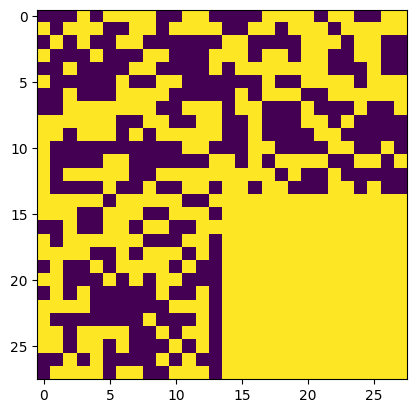

In [107]:
# plt.subplot(121)
plt.imshow(poisoned_train[0][:,:,0])

In [108]:
POISON_RATE = 0.2

num_poison_train  = int(20000 * POISON_RATE)
poison_idx_train  = np.random.choice(20000, num_poison_train, replace=False)
for i in poison_idx_train:
    img_train[i] = poisoned_train[i]

img_test_clean = copy.deepcopy(img_test)
label_test_clean =  copy.deepcopy(label_test)
for i in range(6000):
    img_test[i] = poisoned_test[i]
    label_test[i] = 1 if label_test[i] == 9 else label_test[i]+1

In [109]:
# how much data will be considered
count_train = 10000
count_test = 3000
n_operands = 2

# operation
op = lambda args: args[0]%args[1]

# train data
img_per_operand_train = [img_train[i*count_train:i*count_train+count_train] for i in range(n_operands)]
label_per_operand_train = [label_train[i*count_train:i*count_train+count_train] for i in range(n_operands)]
label_result_train = np.apply_along_axis(op,0,label_per_operand_train)

# test data
img_per_operand_test = [img_test[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_per_operand_test = [label_test[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_result_test = np.apply_along_axis(op,0,label_per_operand_test)

# test data clean
img_per_operand_test_clean = [img_test_clean[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_per_operand_test_clean = [label_test_clean[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_result_test_clean = np.apply_along_axis(op,0,label_per_operand_test_clean)

## Creating tf datasets of specific buffer and batch size

In [110]:
buffer_size = 3000
batch_size  = 16

# training set
ds_train = tf.data.Dataset.from_tensor_slices(
              ((img_per_operand_train[0],
                img_per_operand_train[1]),
               label_result_train)
           )\
           .shuffle(buffer_size)\
           .batch(batch_size)\
           .prefetch(tf.data.AUTOTUNE)

# test set
ds_test  = tf.data.Dataset.from_tensor_slices(
              ((img_per_operand_test[0],
                img_per_operand_test[1]),
               label_result_test)
           )\
           .batch(batch_size)\
           .prefetch(tf.data.AUTOTUNE)

# making the clean test dataset
ds_test_clean = tf.data.Dataset.from_tensor_slices(
              ((img_per_operand_test_clean[0],
                img_per_operand_test_clean[1]),
               label_result_test_clean)
           )\
            .take(count_test).shuffle(buffer_size).batch(batch_size)

## Neural Network

In [111]:
# Instantiate model
n_classes = 9
model = baselines.MultiDigits(n_classes=n_classes, hidden_dense_sizes=(84,))

# Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train
history = model.fit(ds_train, epochs=10)
test_loss, test_accuracy = model.evaluate(ds_test_clean)
print(f"Test accuracy: {test_accuracy:.4f}")
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Attack success rate: {test_accuracy:.4f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4530 - loss: 1.4617
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6937 - loss: 0.7968
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8288 - loss: 0.4728
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8989 - loss: 0.2848
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9386 - loss: 0.1825
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9575 - loss: 0.1240
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9724 - loss: 0.0850
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9699 - loss: 0.0863
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9847 - loss: 0.0466
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9819 - loss: 0.0484
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9137 - loss: 0.3439
Test accuracy: 0.9130
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -